# Лекция 2. Углубление в НС и библиотеку Keras


In [177]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
try:
    import cv2
except:
    !python -m pip install opencv-python -q
    import cv2
try:
    import skimage
except:
    !python -m pip install -U scikit-image
    import skimage

## Introduction

На прошлой лекции мы познакомились с базовым набором инструментов библиотеки Keras, научились строить модели с помощью инструмента ```keras.Sequential()```. Однако на практике не все модели удается реализовать с помощью этого метода.

Если в модели присутствует "нелинейная" структура (т.е. есть разветвление потока данных), то ```keras.Sequential()``` не подойдет для построения такой модели. На помощь приходит инструмент *functional API*.


Рассмотрим следующую модель:

<div class="k-default-codeblock">
```
(input: 784-dimensional vectors)
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (32 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
</div>

Обычно в глубоком обучении принято использовать следующую структуру во входных данных:

$$[n, N_{ch}, W,H],$$

где $n$ - размер подвыборки (batch_size), $N_{ch}$ - кол-во каналов (красный, зеленый, синий), $W$, $H$ - ширина и высота изображения. Однако batch_size не указывается при объявлении слоев в Keras. 



In [178]:
img_inputs = keras.Input(shape=(32, 32, 3))
print(img_inputs.shape)

(None, 32, 32, 3)


На сегодняшний день мы пока забудем о вышеописанной структуре и будем все входные данные трактовать как один длинный вектор длины $(N_{ch}\cdot W \cdot H)$.

In [179]:
28*28

784

In [180]:
inputs = keras.Input(shape=(784,))

In [181]:
print("Shape of input is", inputs.shape)
print("Data type of input is", inputs.dtype)

Shape of input is (None, 784)
Data type of input is <dtype: 'float32'>


Следующий слой, который будет использовать тензор `inputs` как входные данные, должен быть объявлен следующим образом:


In [182]:
x = layers.Dense(28)(inputs) ### объявление слоя
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Activation('relu')(x)

y = layers.Dense(28)(inputs)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Activation('relu')(y)

dense21 = layers.Dense(28, activation="relu")(x)
dense22 = layers.Dense(28, activation='relu')(y)

dense3 = layers.Add()([dense21, dense22])

In [183]:
x = layers.Dense(28, activation="relu")(dense3)
outputs = layers.Dense(10)(x)

На этом этапе мы можем закончить добавление новых блоков и объявить модель, которая будет состоять из данных слоёв:

In [184]:
model = keras.Model(inputs=inputs, outputs=outputs, name="our_second_model")

In [185]:
model.summary()

Model: "our_second_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_38 (Dense)               (None, 28)           21980       ['input_12[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 28)           21980       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 28)          112         ['dense_38[0][0]']               
 ormalization)                                                                     

Можно, например, нарисовать модель в виде направленного графа:

In [186]:
keras.utils.plot_model(model, "my_first_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [187]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [188]:
!python -m pip install graphviz

## Обучение модели

Обучение модели происходит тем же самым образом, что и модели, объявленной с помощью класса ```Sequential()```, т.е. с помощью метода ```fit()```.


In [189]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [190]:
y_train.shape

(60000,)

In [191]:
x_train = x_train.reshape(60000, 784).astype("float32") / 255.
x_test = x_test.reshape(10000, 784).astype("float32") / 255.

model.compile(
    # suitable for multi-class classification tasks where the target labels are integers.
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # gradient descent optimization algorithm that adapts the learning rate based on the moving average of the squared gradients.
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)


Epoch 1/10
750/750 [==============================] - 3s 2ms/step - loss: 0.6840 - accuracy: 0.7920 - val_loss: 0.2560 - val_accuracy: 0.9245
Epoch 2/10
750/750 [==============================] - 1s 2ms/step - loss: 0.4331 - accuracy: 0.8687 - val_loss: 0.2220 - val_accuracy: 0.9346
Epoch 3/10
750/750 [==============================] - 2s 2ms/step - loss: 0.3832 - accuracy: 0.8844 - val_loss: 0.1990 - val_accuracy: 0.9406
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3619 - accuracy: 0.8920 - val_loss: 0.1893 - val_accuracy: 0.9438
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3427 - accuracy: 0.8978 - val_loss: 0.1652 - val_accuracy: 0.9524
Epoch 6/10
750/750 [==============================] - 2s 2ms/step - loss: 0.3279 - accuracy: 0.9001 - val_loss: 0.1617 - val_accuracy: 0.9537
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3166 - accuracy: 0.9041 - val_loss: 0.1625 - val_accuracy: 0.9530
Epoch 

In [192]:
# evaluate the trained model on the test dataset.
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 0s - loss: 0.1591 - accuracy: 0.9526 - 252ms/epoch - 804us/step
Test loss: 0.15905828773975372
Test accuracy: 0.9526000022888184


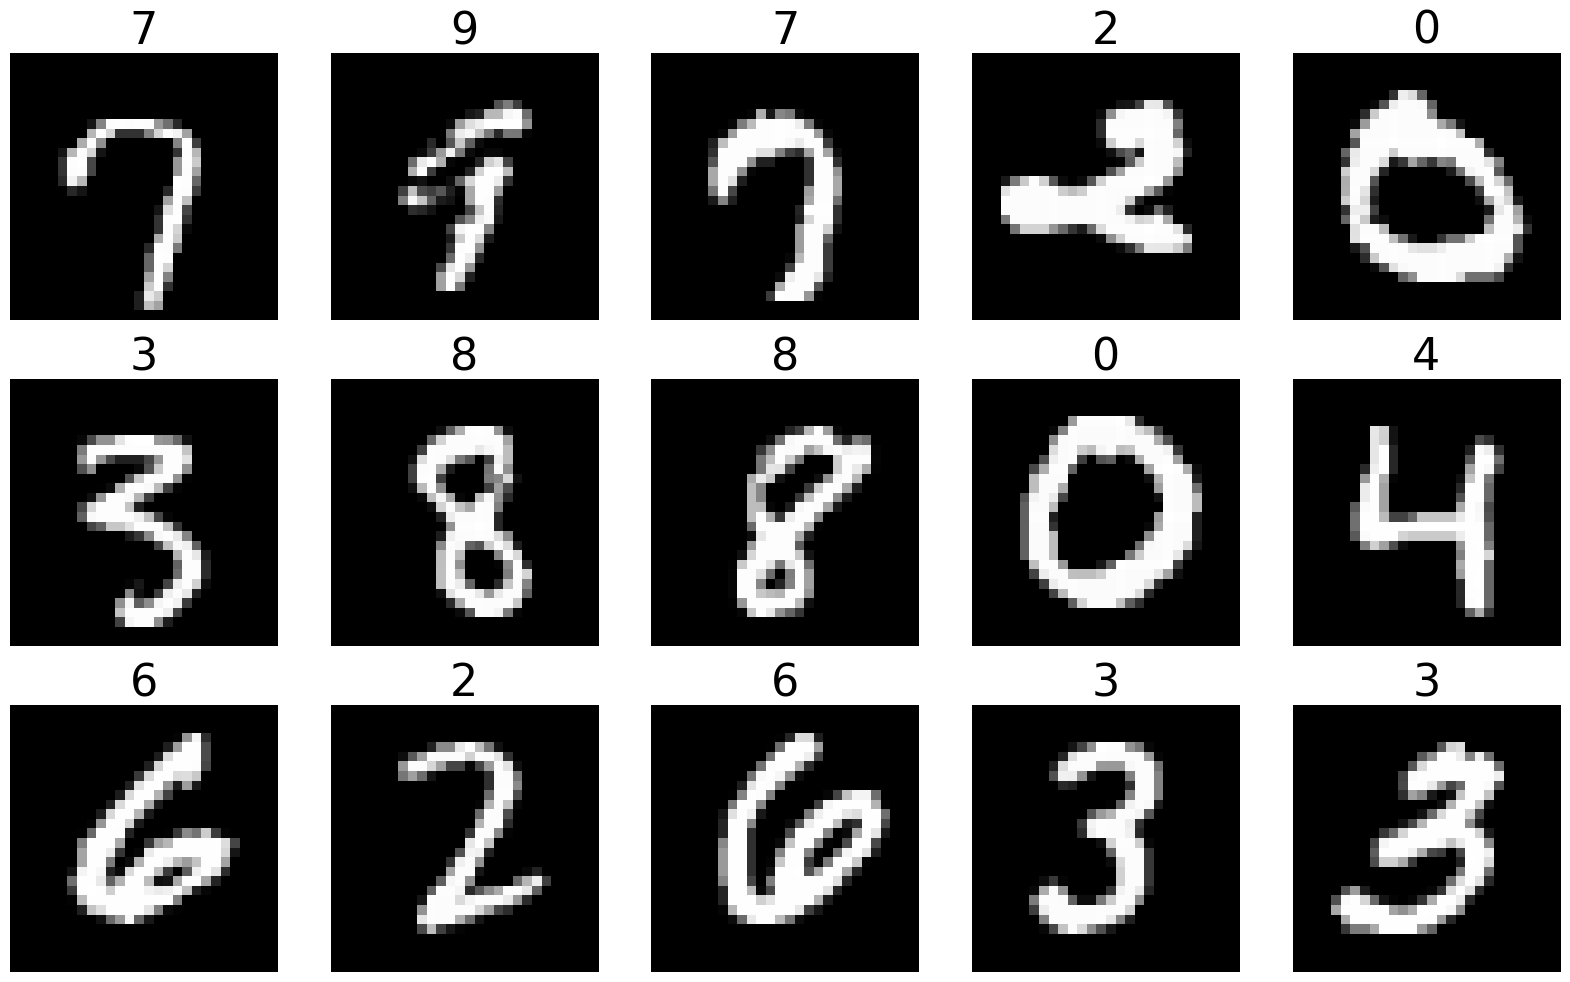

In [193]:
plt.figure(figsize=(20, 12))
for i in range(15):
    k= np.random.randint(0, 10000)

    temp_img = x_test[k].reshape(28,28)
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    plt.title(f"{y_test[k]}", fontsize=32)


plt.show()

## Сохранение модели

 `model.save()` при вызове сохраняет модель в один файл.
Сохраненный файл включает в себя:
- архитектуру модели;
- веса модели;
- config-file (если такой был создан при компиляции);
- оптимизатор и его состояние.

In [194]:
model.save("Keras_lecture_2_MNIST")
del model

2023-06-03 12:19:25.984527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28]
	 [[{{node inputs}}]]
2023-06-03 12:19:25.992675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28]
	 [[{{node inputs}}]]
2023-06-03 12:19:26.356648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28]
	 [[{{node inputs}}]]
2023-06-03 12:19:26

INFO:tensorflow:Assets written to: Keras_lecture_2_MNIST/assets


INFO:tensorflow:Assets written to: Keras_lecture_2_MNIST/assets


In [195]:
# Recreate the exact same model purely from the file:
model = keras.models.load_model("Keras_lecture_2_MNIST")

In [196]:
model.summary()

Model: "our_second_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_38 (Dense)               (None, 28)           21980       ['input_12[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 28)           21980       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 28)          112         ['dense_38[0][0]']               
 ormalization)                                                                     